In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras
from tensorflow.keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
# from keras.layers.experimental import preprocessing
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_DATASET=r"/content/drive/MyDrive/Colab Notebooks/DATASET"
TRAIN_DIR=r"/content/drive/MyDrive/Colab Notebooks/DATASET/TRAIN"
# VAL_DIR=r"/mnt/c/Users/.../Documents/BANGKIT/Capstone/splitedDataset/val_ds"
TEST_DIR=r"/content/drive/MyDrive/Colab Notebooks/DATASET/TEST"

Menghapus batik geblek renteng dan sekar jagad

In [ ]:
CLASSES = ["Batik Cendrawasih", "Batik Ikat Celup", "Batik Insang", "Batik Kawung", "Batik Lasem", "Batik Megamendung", "Batik Pala", "Batik Parang", "Batik Poleng", "Batik Tambal"]

In [ ]:
def create_datasets(TRAIN_DIR, TEST_DIR):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        seed=0,
        batch_size=20,
        label_mode='categorical',
        image_size=(224, 224),
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        seed=0,
        batch_size=20,
        label_mode='categorical',
        image_size=(224, 224),
    )

    val_size = int(0.2 * len(train_ds))
    train_ds = train_ds.skip(val_size)
    validation_ds = train_ds.take(val_size)

    return train_ds, validation_ds, test_ds

In [ ]:
train_ds, validation_ds, test_ds = create_datasets(TRAIN_DIR, TEST_DIR)

Found 700 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


In [ ]:
IMG_SHAPE = (224, 224, 3)
base_model = keras.applications.EfficientNetV2S(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
    include_preprocessing=False,
)
# fine tuning - https://keras.io/guides/transfer_learning/#freezing-layers-understanding-the-trainable-attribute
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Melatih hanya 20 lapisan terakhir
    layer.trainable = False
# base_model.summary()

tuning_layer_name = 'block5a_expand_conv'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)
for layer in base_model.layers[:tuning_index]:
    layer.trainable =  False

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset= -1),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
], name='data_augmentation')

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model = Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    base_model,
    Conv2D(256, (3, 3), activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

learning_rate = 0.00001
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            accuracy = logs.get('accuracy')
            val_accuracy = logs.get('val_accuracy')
            if accuracy is not None and val_accuracy is not None:
                if accuracy >= 0.92 and val_accuracy >= 0.92:
                    self.model.stop_training = True
                    print("\nReached 90% train accuracy and 90% validation accuracy, so cancelling training!")

In [ ]:
early_stopping = EarlyStoppingCallback()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model2.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
epochs = 250
batch_size = 32
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds,
                    batch_size=batch_size, callbacks=[early_stopping, checkpoint])

Epoch 1/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - accuracy: 0.1129 - loss: 2.6060 - val_accuracy: 0.1571 - val_loss: 2.3477
Epoch 2/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.1754 - loss: 2.3417 - val_accuracy: 0.2214 - val_loss: 2.1604
Epoch 3/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.2576 - loss: 2.1615 - val_accuracy: 0.2500 - val_loss: 2.1087
Epoch 4/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.2471 - loss: 2.1035 - val_accuracy: 0.3714 - val_loss: 2.0172
Epoch 5/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.3984 - loss: 1.9249 - val_accuracy: 0.4357 - val_loss: 1.9152
Epoch 6/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.4503 - loss: 1.8717 - val_accuracy: 0.5357 - val_loss: 1.7507
Epoch 7/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.4816 - loss: 1.7663 - val_accuracy: 0.5214 - val_loss: 1.6515
Epoch 8/250
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.5416 - loss: 1.6896 - val_accur

#PREDICT


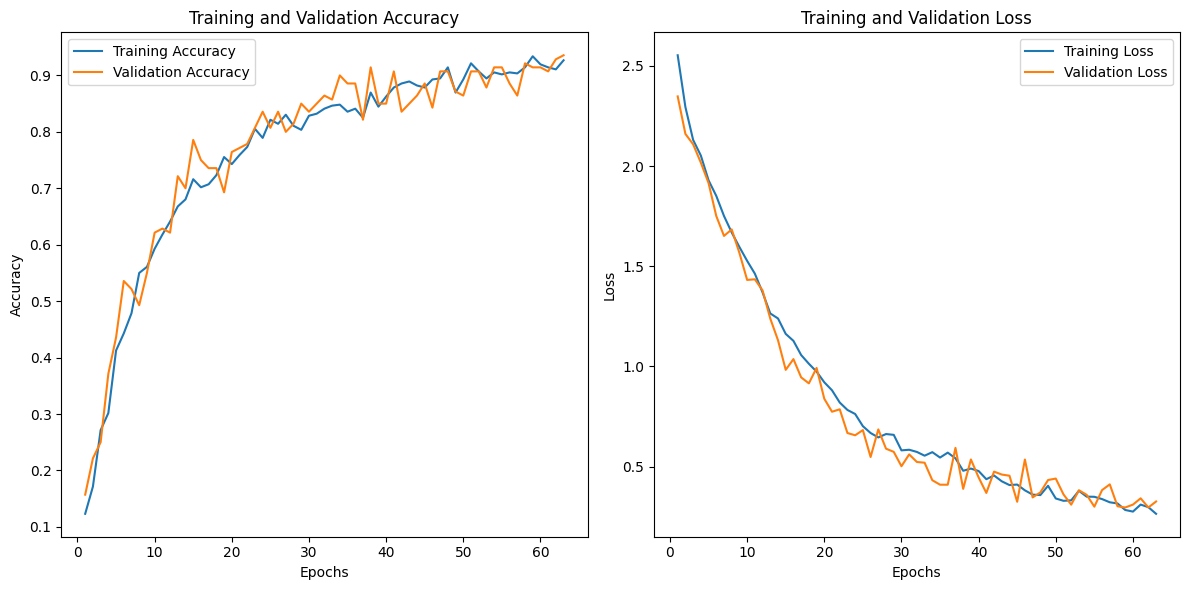

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
F1 Score: 0.8487

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.92      0.60      0.73        20
           2       0.83      1.00      0.91        20
           3       0.94      0.85      0.89        20
           4       0.80      0.80      0.80        20
           5       0.95      0.95      0.95        20
           6       0.67      0.80      0.73        20
           7       0.84      0.80      0.82        20
           8       1.00      1.00      1.00        20
           9       0.86      0.90      0

In [ ]:
def evaluate_test_data(model, test_ds, motives_dict):
    idx_to_class = {idx: name for name, idx in motives_dict.items()}

    class_correct = {class_name: 0 for class_name in idx_to_class.values()}
    class_total = {class_name: 0 for class_name in idx_to_class.values()}

    for batch_images, batch_labels in test_ds:
        predictions = model.predict(batch_images)
        predicted_indices = tf.argmax(predictions, axis=1).numpy()
        true_indices = tf.argmax(batch_labels, axis=1).numpy()

        for true_idx, pred_idx in zip(true_indices, predicted_indices):
            true_class = idx_to_class[true_idx]
            class_total[true_class] += 1
            if true_idx == pred_idx:
                class_correct[true_class] += 1

    print("\nTes Akurasi Model:")
    for class_name, correct_count in class_correct.items():
        total_count = class_total[class_name]
        accuracy = (correct_count / total_count) * 100 if total_count > 0 else 0
        print(f"{class_name}: {correct_count}/{total_count} correct ({accuracy:.2f}%)")

class_names = test_ds.class_names
motives_dict = {name: idx for idx, name in enumerate(class_names)}


evaluate_test_data(model, test_ds, motives_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Tes Akurasi Model:
Batik Cendrawasih: 16/20 correct (80.00%)
Batik Ikat Celup: 12/20 correct (60.00%)
Batik Insang: 20/20 correct (100.00%)
Batik Kawung: 17/20 correct (85.00%)
Batik Lasem: 16/20 correct (80.00%)
Batik Megamendung: 19/20 correct (95.00%)
Batik Pala: 16/20 correct (80.00%)
Batik Parang: 16/20 correct (80.00%)
Batik Poleng: 20/20 correct (100.00%)
Batik Tambal: 18/20 correct (90.00%)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


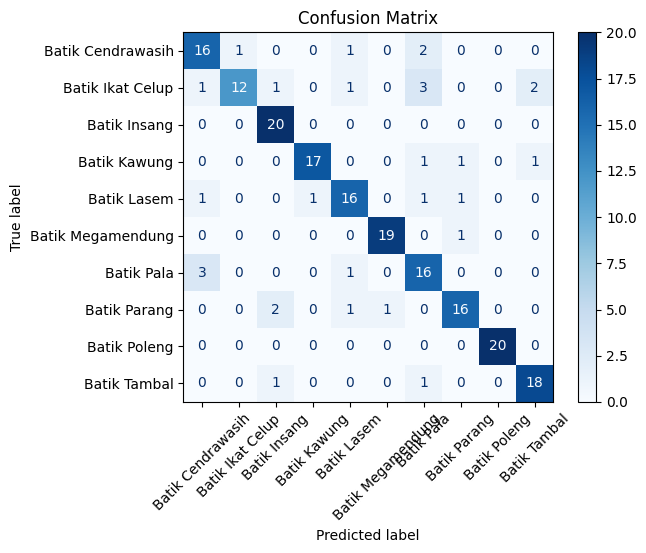

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = np.argmax(labels.numpy(), axis=1)
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_ds.class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

In [ ]:
model.save('model_10_classes_1.keras')
print("Model successfully saved as 'model_trained.keras'")

Model successfully saved as 'model_trained.keras'


In [ ]:
from google.colab import files
files.download('model_10_classes_1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import ipywidgets as widgets
# from io import BytesIO

# uploader = widgets.FileUpload(accept="image/*", multiple=False)
# display(uploader)
# out = widgets.Output()
# display(out)

# def file_predict(filename, file, out):
#     try:
#         image = tf.keras.utils.load_img(file, target_size=(224, 224))
#         image = tf.keras.utils.img_to_array(image)
#         image = (image / 127.5) - 1.0
#         image = np.expand_dims(image, axis=0)

#         prediction = model.predict(image, verbose=0)[0]

#         with out:
#             out.clear_output()
#             print(f'\nModel output: {prediction}')
#             prediction_index = np.argmax(prediction)
#             CLASSES = ["Batik Cendrawasih", "Batik Geblek Renteng", "Batik Ikat Celup", "Batik Insang", "Batik Kawung", "Batik Lasem", "Batik Megamendung", "Batik Parang", "Batik Poleng", "Batik Tambal"]
#             predicted_class = CLASSES[prediction_index]

#             print(f'{filename} adalah {predicted_class}')
#     except Exception as e:
#         with out:
#             out.clear_output()
#             print(f"Error processing {filename}: {str(e)}")

# def on_upload_change(change):
#     for filename, fileinfo in change['new'].items():
#         file_data = BytesIO(fileinfo['content'])
#         file_predict(filename, file_data, out)

# uploader.observe(on_upload_change, names='value')